EPIC-55: https://epic-kitchens.github.io/2020-55.html#arModels

EPIC-55 annotation: https://github.com/epic-kitchens/epic-kitchens-55-annotations/blob/master/EPIC_train_object_labels.csv

EPIC download script: https://github.com/epic-kitchens/epic-kitchens-download-scripts

# Prepare data
由于epic 55的标签格式不符合darknet输入格式，需要先进行转换。

In [1]:
# 下载脚本
!git clone https://github.com/SuyueLiu/dl-label-conversion.git
%cd dl-label-conversion

Cloning into 'dl-label-conversion'...
remote: Enumerating objects: 19, done.
remote: Counting objects: 100% (19/19), done.
remote: Compressing objects: 100% (13/13), done.
remote: Total 19 (delta 5), reused 17 (delta 4), pack-reused 0
Unpacking objects: 100% (19/19), done.
/Users/aaron/Desktop/code/dissertation-diary/dl-label-conversion


In [3]:
# download annotation files
!git clone https://github.com/epic-kitchens/epic-kitchens-55-annotations.git

Cloning into 'epic-kitchens-55-annotations'...
remote: Enumerating objects: 110, done.
remote: Counting objects: 100% (110/110), done.
remote: Compressing objects: 100% (71/71), done.
remote: Total 661 (delta 81), reused 58 (delta 39), pack-reused 551
Receiving objects: 100% (661/661), 22.46 MiB | 4.32 MiB/s, done.
Resolving deltas: 100% (437/437), done.


In [1]:
cd dl-label-conversion/

/Users/aaron/Desktop/code/dissertation-diary/dl-label-conversion


In [2]:
# ann_path = './epic-kitchens-55-annotations/EPIC_train_object_labels.csv'
# names_path = './epic-kitchens-55-annotations/EPIC_noun_classes.csv'
# train_data_dir = './epic55_sample/train'
# val_data_dir = './epic55_sample/val'
# output_dir = './epic55-darknet'


In [25]:
# trainning data without NMS
!python epic2darknet.py --org_ann_path './epic-kitchens-55-annotations/EPIC_train_object_labels.csv' --org_names_path './epic-kitchens-55-annotations/EPIC_noun_classes.csv' --org_dataset_dir './epic55_sample/train' --out_dir './epic55-darknet'

moving images (P01_P01_03): 100%|███████████████| 5/5 [00:00<00:00, 1481.88it/s]


In [26]:
# val data without NMS
!python epic2darknet.py --org_ann_path './epic-kitchens-55-annotations/EPIC_train_object_labels.csv' --org_names_path './epic-kitchens-55-annotations/EPIC_noun_classes.csv' --org_dataset_dir './epic55_sample/val' --out_dir './epic55-darknet' --mode 'val' --write_flag True

moving images (P16_P16_02): 100%|███████████████| 3/3 [00:00<00:00, 1550.57it/s]


Image: './epic55-darknet/images/train/P01_P01_04-0000000631.jpg'


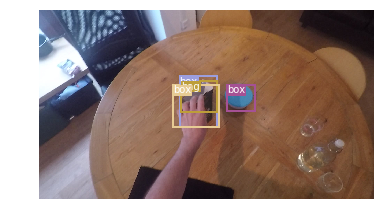

In [7]:
# veryify labels
%matplotlib inline
%run verify_labels.py --img_path './epic55-darknet/images/train/P01_P01_04-0000000631.jpg' --label_path './epic55-darknet/labels/train/P01_P01_04-0000000631.txt' --names_path './epic55-darknet/epic55-darknet.names'

In [28]:
!cat './epic55-darknet/labels/train/P01_P01_04-0000000631.txt'

39 0.602604 0.464815 0.084375 0.140741
39 0.474479 0.485185 0.111458 0.270370
20 0.476562 0.458333 0.107292 0.164815
39 0.467708 0.507407 0.137500 0.225926


In [14]:
# 可以看到目标边框是贴合实际对象的，这里有个小坑，epic55_train_object_labels边界框的标注是<y1, x1, h, w>

# 训练结果

训练参数：
batch size: 20，epochs: 150，image size: 608

使用Slurm提交作业到服务器端训练，单机双卡，16G显存，shell文件：https://github.com/SuyueLiu/dissertation-diary/blob/master/epic55-train.sh

训练结果：

![](https://suyueliu-blog-img.oss-cn-beijing.aliyuncs.com/images/epic55-object-detection-62epochs.png)

训练结果很差，跑了60多个轮了，mAP才0.025，训练已经停止了。

## 原因分析

最有可能的原因就是数据出现问题，因为模型并没有做修改。

In [15]:
import pandas as pd
ann_path = './epic-kitchens-55-annotations/EPIC_train_object_labels.csv'
names_path = './epic-kitchens-55-annotations/EPIC_noun_classes.csv'
anns = pd.read_csv(ann_path)
print(anns.columns.values.tolist())
ann_indices = [6783, 6806, 6821] # 对应于P01_04-0000000631.jpg这张图片在csv中的缩影
for idx in ann_indices:
    print(anns.loc[idx].tolist())


['noun_class', 'noun', 'participant_id', 'video_id', 'frame', 'bounding_boxes']
[39, 'box', 'P01', 'P01_04', 631, '[(426, 1076, 152, 162), (378, 804, 292, 214)]']
[20, 'cereal bag', 'P01', 'P01_04', 631, '[(406, 812, 178, 206)]']
[39, 'cereal box', 'P01', 'P01_04', 631, '[(426, 766, 244, 264)]']


In [16]:
names = pd.read_csv(names_path)
print(names.columns.values.tolist())
print(names.loc[20].tolist())
print(names.loc[39].tolist())

['noun_id', 'class_key', 'nouns']
[20, 'bag', "['bag', 'bag:plastic', 'bag:pasta', 'bag:mozzarella', 'bag:cereal', 'bag:grape', 'bag:flour', 'bag:cheese', 'bag:nut', 'bag:rice', 'bag:oregano', 'bag:salad', 'bag:bin', 'bag:coffee', 'bag:spaghetti', 'bag:food', 'bag:trash', 'bag:onion', 'bag:carrot', 'bag:bread', 'bag:grapes', 'bag:sandwich', 'bag:kitchen']"]
[39, 'box', "['box', 'box:lunch', 'box:cereal', 'box:tea', 'box:salt', 'tupperware', 'lunchbox', 'case', 'box:mushroom', 'box:coffee', 'box:cheese', 'box:milk', 'box:rice', 'box:carrot', 'box:fruit', 'pot:plastic', 'tub', 'box:plastic', 'box:eggs', 'box:fajita']"]


Image: './epic55-darknet/images/train/P01_P01_04-0000000631.jpg'


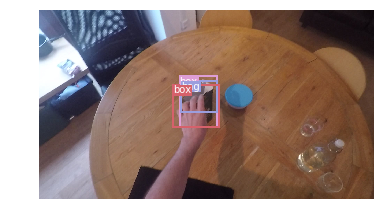

39 0.474479 0.485185 0.111458 0.270370
20 0.476562 0.458333 0.107292 0.164815
39 0.467708 0.507407 0.137500 0.225926


In [20]:
# 删除txt文件中第一行的数据
%run verify_labels.py --img_path './epic55-darknet/images/train/P01_P01_04-0000000631.jpg' --label_path './epic55-darknet/labels/train/P01_P01_04-0000000631.txt' --names_path './epic55-darknet/epic55-darknet.names'
!cat './epic55-darknet/labels/train/P01_P01_04-0000000631.txt'

**现象分析：**
1. 关于\*.names文件，我只提取了csv文件中class_key这一列，一共是352个，但其实在具体的标签中，还包含了nouns里面的实例。例如，P0_P01_04-0000000631.jpg这张图片，手周围的盒子一共有3个bounding boxes，这是3个boxes对应2个类别，bag(20)和box(39)。
2. 这会造成一个两方面的问题。第一，保留所有的bounding boxes的话，这就成了multi-label classification，虽然在YOLO V3的论文中提到了支持multi-label classification。但由于标签的设置，会造成第二个问题，模型的表达比较宽泛，只能表达到更为浅层次的类别。比如模型最终预测这个盒子的标签是bag，在bag这个类别下，实际cereal bag更为准确，人们也更能够明白。

**已经尝试的解决方法：**
* 利用类似于NMS的方法，把指向同一物体的bounding boxes去重，只保留其中一个，这样就成了single-label classification了，即一个物体只对应一个标签。但是这个会出现一个问题，对于靠得比较近的两个物体，会被误伤，因为我们只是通过IoU来判断。我起初想的是把这个人物变成是single-label的，舍弃一部分物体的标注。



In [4]:
# train set with NMS
!python epic2darknet.py --org_ann_path './epic-kitchens-55-annotations/EPIC_train_object_labels.csv' --org_names_path './epic-kitchens-55-annotations/EPIC_noun_classes.csv' --org_dataset_dir './epic55_sample/train' --out_dir './epic55-darknet-nms' --mode 'train' --iou_thres 0.3

moving images (P01_P01_03): 100%|███████████████| 5/5 [00:00<00:00, 2061.89it/s]


In [5]:
# val set with NMS
!python epic2darknet.py --org_ann_path './epic-kitchens-55-annotations/EPIC_train_object_labels.csv' --org_names_path './epic-kitchens-55-annotations/EPIC_noun_classes.csv' --org_dataset_dir './epic55_sample/val' --out_dir './epic55-darknet-nms' --iou_thres 0.3 --mode 'val' --write_flag True

moving images (P16_P16_02): 100%|███████████████| 3/3 [00:00<00:00, 1825.99it/s]


Image: './epic55-darknet-nms/images/train/P01_P01_04-0000000631.jpg'


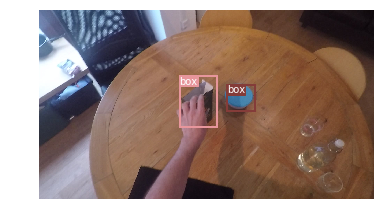

39 0.602604 0.464815 0.084375 0.140741
39 0.474479 0.485185 0.111458 0.270370


In [8]:
%matplotlib inline
%run verify_labels.py --img_path './epic55-darknet-nms/images/train/P01_P01_04-0000000631.jpg' --label_path './epic55-darknet-nms/labels/train/P01_P01_04-0000000631.txt' --names_path './epic55-darknet/epic55-darknet.names'
!cat './epic55-darknet-nms/labels/train/P01_P01_04-0000000631.txt'

**结果分析：**

如上图所示，虽然把multi-label转换成了single-label，但是图片中的objects其实是减少了。如果采用EPIC_train_object_labels.csv里面的class_key做为names文件，相当于是352类的检测。由于EPIC-55的数据量非常大， 原始图片一共是350934张。我采用P02、P05、P15、P16、P20、P23做为训练集，P27做为验证集，P19、P30做为测试集。去除标签文件中不含目标的图片之后，train:val:test = 32047:1978:11909。整个训练集只有原数据的十分之一，对于352个类别来说，我觉得可能会出现类别不均衡的或者某个类别的目标图片太少了，所以导致网络学习不到东西。

**后续可能的解决方案：**

1. 挑选几个类别，重组数据集，针对性的训练网络；
2. 继续保留多标签格式。